<a href="https://colab.research.google.com/github/HEDAEATULISLAMS/Neural-Network-Fuzzy-Logic-Lab-Project/blob/main/Banglish_Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D,
                                   Flatten, Dense, Dropout, BatchNormalization,
                                   GlobalMaxPooling1D, concatenate, LSTM, Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load and explore dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as mtp
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASET/Banglish Hate Speech Dataset.csv')
print(df)

#df = pd.read_csv('Banglish_Hate_Speech_Dataset.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst 5 rows:")
print(df.head())
print("\nHate Distribution:")
print(df['Hate'].value_counts())
print("\nType Distribution:")
print(df['Type'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
      SL.                                             Comment Hate        Type
0        1             Kanki ki der Allah sob samoy valo rake  Yes      Others
1        2                                        khanki akta  Yes      Sexual
2        3                                      Ore saniliyon  Yes      Sexual
3        4                               Bokachoda Shangbadik  Yes       Slang
4        5                                    Balda dekhaiche  Yes       Slang
...    ...                                                ...  ...         ...
4995  4996                    erum chahara loya gf asha koros  Yes  Appearance
4996  4997  tor ma durga ar radha ke bol amake shukh dia jete  Yes   Religious
4997  4998                            tora to nun puja korish  Yes   Religious
4998  4999  malaun er bachchader dekhle bojha jau malura k...  Yes   Religious
49

In [ ]:
# Advanced Data Preprocessing
class BanglishTextPreprocessor:
    def __init__(self):
        self.bangla_stopwords = set(['ami', 'tumi', 'se', 'amra', 'tomra', 'ora', 'ki', 'kono',
                                   'eke', 'oke', 'jodi', 'je', 'na', 'ar', 'ebong', 'ba',
                                   'hoi', 'hoy', 'ache', 'nai', 'kore', 'kora', 'korbe'])

    def clean_text(self, text):
        if pd.isna(text):
            return ""

        # Convert to string and lowercase
        text = str(text).lower()

        # Remove special characters but keep Bangla and English characters
        text = re.sub(r'[^\w\s\u0980-\u09FF]', ' ', text)

        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        return text.strip()

    def remove_stopwords(self, text):
        words = text.split()
        filtered_words = [word for word in words if word not in self.bangla_stopwords]
        return ' '.join(filtered_words)

# Initialize preprocessor
preprocessor = BanglishTextPreprocessor()

# Apply preprocessing
df['cleaned_comment'] = df['Comment'].apply(preprocessor.clean_text)
df['cleaned_comment'] = df['cleaned_comment'].apply(preprocessor.remove_stopwords)

# Remove empty comments after cleaning
df = df[df['cleaned_comment'].str.len() > 0]

print(f"After cleaning: {len(df)} comments remaining")
print("\nSample cleaned comments:")
for i in range(3):
    print(f"Original: {df['Comment'].iloc[i][:100]}...")
    print(f"Cleaned: {df['cleaned_comment'].iloc[i][:100]}...")
    print("-" * 50)

After cleaning: 5000 comments remaining

Sample cleaned comments:
Original: Kanki ki der Allah sob samoy valo rake...
Cleaned: kanki der allah sob samoy valo rake...
--------------------------------------------------
Original: khanki akta...
Cleaned: khanki akta...
--------------------------------------------------
Original: Ore saniliyon...
Cleaned: ore saniliyon...
--------------------------------------------------


Text(0.5, 1.0, 'Hate vs Non-Hate Distribution')

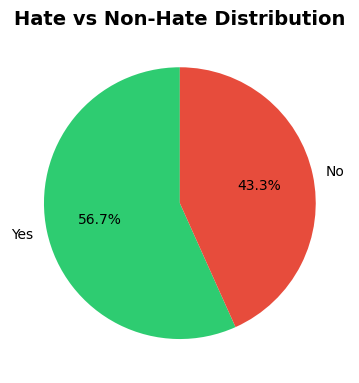

In [ ]:
# Comprehensive EDA with Advanced Visualizations
plt.figure(figsize=(20, 15))

# 1. Hate vs Non-Hate distribution
plt.subplot(3, 3, 1)
hate_counts = df['Hate'].value_counts()
colors = ['#2ecc71', '#e74c3c']
plt.pie(hate_counts.values, labels=hate_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Hate vs Non-Hate Distribution', fontsize=14, fontweight='bold')


Text(0, 0.5, 'Count')

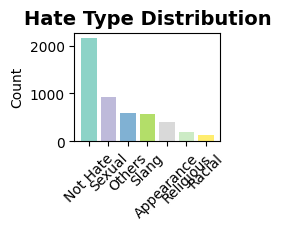

In [ ]:

# 2. Type distribution with custom colors
plt.subplot(3, 3, 2)
type_counts = df['Type'].value_counts()
type_colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
plt.bar(range(len(type_counts)), type_counts.values, color=type_colors)
plt.xticks(range(len(type_counts)), type_counts.index, rotation=45)
plt.title('Hate Type Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')



Text(0.5, 1.0, 'Breakdown of Hate Types')

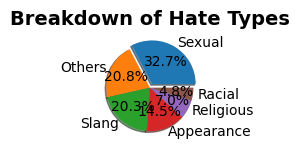

In [ ]:
# 3. Hate types breakdown
plt.subplot(3, 3, 3)
hate_df = df[df['Hate'] == 'Yes']
hate_type_counts = hate_df['Type'].value_counts()
explode = [0.1 if i == 0 else 0 for i in range(len(hate_type_counts))]
plt.pie(hate_type_counts.values, labels=hate_type_counts.index, autopct='%1.1f%%',
        explode=explode, shadow=True)
plt.title('Breakdown of Hate Types', fontsize=14, fontweight='bold')


Text(0.5, 1.0, 'Comment Length Distribution')

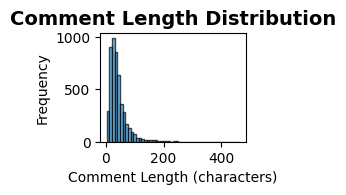

In [ ]:

# 4. Comment length distribution
plt.subplot(3, 3, 4)
df['comment_length'] = df['cleaned_comment'].str.len()
plt.hist(df['comment_length'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
plt.xlabel('Comment Length (characters)')
plt.ylabel('Frequency')
plt.title('Comment Length Distribution', fontsize=14, fontweight='bold')


Text(0.5, 1.0, 'Comment Length by Hate Category')

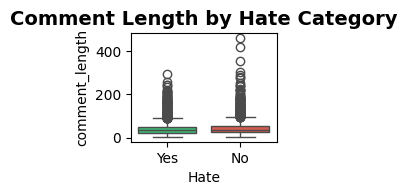

In [ ]:

# 5. Comment length by hate category
plt.subplot(3, 3, 5)
sns.boxplot(x='Hate', y='comment_length', data=df, palette=colors)
plt.title('Comment Length by Hate Category', fontsize=14, fontweight='bold')



Text(0.5, 1.0, 'Word Count Distribution')

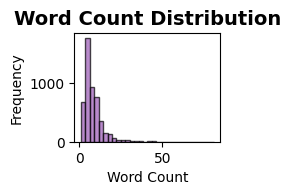

In [ ]:
# 6. Word count distribution
plt.subplot(3, 3, 6)
df['word_count'] = df['cleaned_comment'].str.split().str.len()
plt.hist(df['word_count'], bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution', fontsize=14, fontweight='bold')


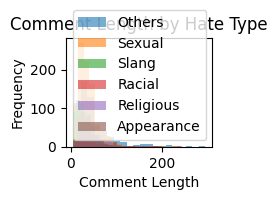

In [ ]:

# 7. Hate type distribution over comment length
plt.subplot(3, 3, 7)
hate_types = df[df['Hate'] == 'Yes']['Type'].unique()
for hate_type in hate_types:
    subset = df[df['Type'] == hate_type]
    plt.hist(subset['comment_length'], alpha=0.6, label=hate_type, bins=20)
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.title('Comment Length by Hate Type')
plt.legend()



Text(0, 0.5, 'Word Count')

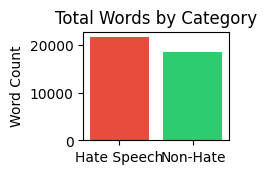

In [ ]:
# 8. Word cloud data preparation (we'll create actual word cloud later)
plt.subplot(3, 3, 8)
hate_words = ' '.join(df[df['Hate'] == 'Yes']['cleaned_comment'])
non_hate_words = ' '.join(df[df['Hate'] == 'No']['cleaned_comment'])
word_counts = [len(hate_words.split()), len(non_hate_words.split())]
plt.bar(['Hate Speech', 'Non-Hate'], word_counts, color=['#e74c3c', '#2ecc71'])
plt.title('Total Words by Category')
plt.ylabel('Word Count')



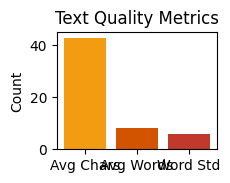


Dataset Statistics:
Average comment length: 42.86 characters
Average word count: 8.06 words
Vocabulary size (approx): 10475 words


In [ ]:
# 9. Data quality metrics
plt.subplot(3, 3, 9)
quality_metrics = [
    df['cleaned_comment'].str.len().mean(),
    df['cleaned_comment'].str.split().str.len().mean(),
    df['cleaned_comment'].str.split().str.len().std()
]
metric_names = ['Avg Chars', 'Avg Words', 'Word Std']
plt.bar(metric_names, quality_metrics, color=['#f39c12', '#d35400', '#c0392b'])
plt.title('Text Quality Metrics')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics
print("\nDataset Statistics:")
print(f"Average comment length: {df['comment_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Vocabulary size (approx): {len(set(' '.join(df['cleaned_comment']).split()))} words")

In [ ]:
# Text Vectorization and Sequence Preparation
class TextVectorizer:
    def __init__(self, max_features=10000, max_len=100):
        self.max_features = max_features
        self.max_len = max_len
        self.tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
        self.label_encoder_binary = LabelEncoder()
        self.label_encoder_multi = LabelEncoder()

    def prepare_binary_data(self, texts, labels):
        # Fit tokenizer
        self.tokenizer.fit_on_texts(texts)

        # Convert texts to sequences
        sequences = self.tokenizer.texts_to_sequences(texts)
        X = pad_sequences(sequences, maxlen=self.max_len)

        # Encode labels
        y = self.label_encoder_binary.fit_transform(labels)

        return X, y

    def prepare_multi_data(self, texts, labels):
        sequences = self.tokenizer.texts_to_sequences(texts)
        X = pad_sequences(sequences, maxlen=self.max_len)

        y = self.label_encoder_multi.fit_transform(labels)
        y = to_categorical(y)

        return X, y

# Initialize vectorizer
vectorizer = TextVectorizer(max_features=10000, max_len=100)

# Prepare binary classification data
X_binary, y_binary = vectorizer.prepare_binary_data(
    df['cleaned_comment'],
    df['Hate']
)

# Prepare multi-class classification data
X_multi, y_multi = vectorizer.prepare_multi_data(
    df[df['Hate'] == 'Yes']['cleaned_comment'],
    df[df['Hate'] == 'Yes']['Type']
)

print("Data Shapes:")
print(f"Binary - X: {X_binary.shape}, y: {y_binary.shape}")
print(f"Multi-class - X: {X_multi.shape}, y: {y_multi.shape}")
print(f"Vocabulary size: {len(vectorizer.tokenizer.word_index)}")

Data Shapes:
Binary - X: (5000, 100), y: (5000,)
Multi-class - X: (2836, 100), y: (2836, 6)
Vocabulary size: 10476


In [ ]:
# Custom CNN Model Architectures
def create_cnn_binary_model(vocab_size, max_len, embedding_dim=100):
    """
    Custom CNN model for binary classification (Hate vs Non-Hate)
    """
    # Input layer
    input_layer = Input(shape=(max_len,))

    # Embedding layer
    embedding = Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        input_length=max_len,
        trainable=True
    )(input_layer)

    # Multiple parallel convolutional branches with different filter sizes
    conv_blocks = []
    filter_sizes = [3, 4, 5]

    for filter_size in filter_sizes:
        # Convolutional layer
        conv = Conv1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu',
            kernel_initializer='he_normal'
        )(embedding)

        # Batch normalization
        conv = BatchNormalization()(conv)

        # Max pooling
        pooled = MaxPooling1D(pool_size=2)(conv)

        # Second convolutional layer
        conv2 = Conv1D(
            filters=64,
            kernel_size=filter_size,
            padding='same',
            activation='relu'
        )(pooled)

        # Global max pooling
        global_pool = GlobalMaxPooling1D()(conv2)
        conv_blocks.append(global_pool)

    # Concatenate all convolutional branches
    concatenated = concatenate(conv_blocks, axis=-1)

    # Dropout for regularization
    dropout1 = Dropout(0.5)(concatenated)

    # Dense layers
    dense1 = Dense(128, activation='relu', kernel_initializer='he_normal')(dropout1)
    batch_norm = BatchNormalization()(dense1)
    dropout2 = Dropout(0.3)(batch_norm)

    dense2 = Dense(64, activation='relu')(dropout2)
    dropout3 = Dropout(0.2)(dense2)

    # Output layer
    output_layer = Dense(1, activation='sigmoid', name='binary_output')(dropout3)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

def create_cnn_multi_model(vocab_size, max_len, num_classes, embedding_dim=100):
    """
    Custom CNN model for multi-class classification (Hate Types)
    """
    input_layer = Input(shape=(max_len,))

    # Embedding layer
    embedding = Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        input_length=max_len,
        trainable=True
    )(input_layer)

    # CNN with LSTM combination
    conv1 = Conv1D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal'
    )(embedding)
    batch_norm1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(pool_size=2)(batch_norm1)

    conv2 = Conv1D(
        filters=64,
        kernel_size=4,
        padding='same',
        activation='relu'
    )(pool1)
    batch_norm2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size=2)(batch_norm2)

    conv3 = Conv1D(
        filters=32,
        kernel_size=5,
        padding='same',
        activation='relu'
    )(pool2)
    batch_norm3 = BatchNormalization()(conv3)

    # Bidirectional LSTM
    lstm = Bidirectional(LSTM(64, return_sequences=True))(batch_norm3)
    global_pool = GlobalMaxPooling1D()(lstm)

    # Dense layers
    dense1 = Dense(128, activation='relu', kernel_initializer='he_normal')(global_pool)
    dropout1 = Dropout(0.5)(dense1)

    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax', name='multi_output')(dropout2)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create models
vocab_size = len(vectorizer.tokenizer.word_index)
max_len = 100
num_multi_classes = len(vectorizer.label_encoder_multi.classes_)

binary_model = create_cnn_binary_model(vocab_size, max_len)
multi_model = create_cnn_multi_model(vocab_size, max_len, num_multi_classes)

print("Binary Classification Model Summary:")
binary_model.summary()



Binary Classification Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 100)  │  1,047,700 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 100, 128)  │     38,528 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 100, 128)  │     51,328 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 100, 128)  │     64,128 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 50, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 50, 64)    │     24,640 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 50, 64)    │     32,832 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 50, 64)    │     41,024 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_12[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_14[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,335,253 (5.09 MB)

 Trainable params: 1,334,229 (5.09 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
print("\nMulti-class Classification Model Summary:")
multi_model.summary()


Multi-class Classification Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     1,047,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 100, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 50, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 25, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 25, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 25, 128)        │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_output (Dense)            │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205,050 (4.60 MB)

 Trainable params: 1,204,602 (4.60 MB)

 Non-trainable params: 448 (1.75 KB)

Text(0.5, 1.0, 'Binary Classification Model Architecture')

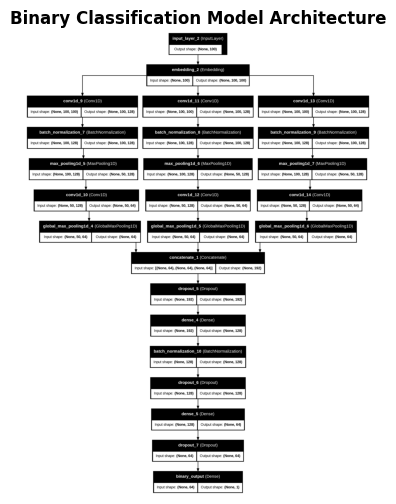

In [ ]:
# Visualize Model Architectures
plt.figure(figsize=(15, 6))

# Plot binary model
plt.subplot(1, 2, 1)
plot_model(binary_model, to_file='binary_model.png', show_shapes=True, show_layer_names=True)
binary_img = plt.imread('binary_model.png')
plt.imshow(binary_img)
plt.axis('off')
plt.title('Binary Classification Model Architecture', fontsize=12, fontweight='bold')



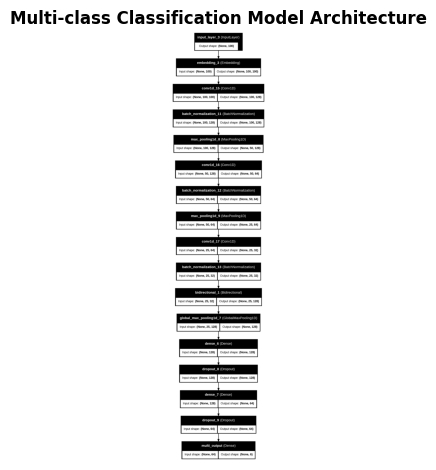

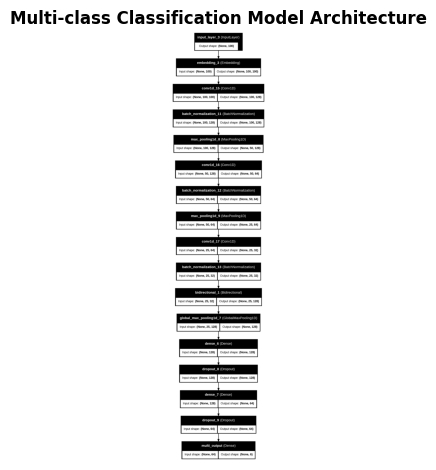

In [ ]:
# Plot multi-class model
plt.subplot(1, 2, 2)
plot_model(multi_model, to_file='multi_model.png', show_shapes=True, show_layer_names=True)
multi_img = plt.imread('multi_model.png')
plt.imshow(multi_img)
plt.axis('off')
plt.title('Multi-class Classification Model Architecture', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Custom Callbacks and Training Configuration
class CustomMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}:")
            for key, value in logs.items():
                print(f"  {key}: {value:.4f}")
            print("-" * 50)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

custom_metrics = CustomMetricsCallback()

callbacks = [early_stopping, reduce_lr, custom_metrics]

In [ ]:
# Train Binary Classification Model
print("Training Binary Classification Model...")

# Split binary data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(
    X_train_bin, y_train_bin, test_size=0.2, random_state=42, stratify=y_train_bin
)

# Train binary model
binary_history = binary_model.fit(
    X_train_bin, y_train_bin,
    validation_data=(X_val_bin, y_val_bin),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\nBinary Model Training Completed!")

Training Binary Classification Model...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.7826 - loss: 0.4626 - precision: 0.7863 - recall: 0.8381 - val_accuracy: 0.5838 - val_loss: 0.7456 - val_precision: 0.5775 - val_recall: 0.9934 - learning_rate: 2.5000e-04
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.8978 - loss: 0.2626 - precision: 0.9039 - recall: 0.9185 - val_accuracy: 0.6762 - val_loss: 0.6468 - val_precision: 0.6628 - val_recall: 0.8744 - learning_rate: 2.5000e-04
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.9534 - loss: 0.1429 - precision: 0.9520 - recall: 0.9650 - val_accuracy: 0.7075 - val_loss: 0.7105 - val_precision: 0.7157 - val_recall: 0.8040 - learning_rate: 2.5000e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.9853 - loss: 0.0692 - precision: 0.9819 - recall: 0.9923 - val_accuracy: 0.7050 - val_loss: 0.8486 - val_precision: 0.7380 - val_recall: 0.7445 - learning_rate: 2.5000e

In [ ]:
# Train Multi-class Classification Model
print("Training Multi-class Classification Model...")

# Split multi-class data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=np.argmax(y_multi, axis=1)
)

X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(
    X_train_multi, y_train_multi, test_size=0.2, random_state=42,
    stratify=np.argmax(y_train_multi, axis=1)
)

# Train multi-class model
multi_history = multi_model.fit(
    X_train_multi, y_train_multi,
    validation_data=(X_val_multi, y_val_multi),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\nMulti-class Model Training Completed!")

Training Multi-class Classification Model...
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.2695 - loss: 1.7340 - val_accuracy: 0.3260 - val_loss: 1.7187 - learning_rate: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.2877 - loss: 1.6380 - val_accuracy: 0.2687 - val_loss: 1.6811 - learning_rate: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.3314 - loss: 1.5309 - val_accuracy: 0.2026 - val_loss: 1.7115 - learning_rate: 0.0010
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.5604 - loss: 1.1539 - val_accuracy: 0.1454 - val_loss: 1.8677 - learning_rate: 0.0010
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7509 - loss: 0.7342Epoch 5:
  accuracy: 0.7459
  loss: 0.7363
  val_accuracy: 0.1454
  val_loss: 2.3666
  learning_rate: 0.0010
--------------------------------------------------
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7508 - loss: 0.7342 - val_accuracy: 0.1454 - val_l

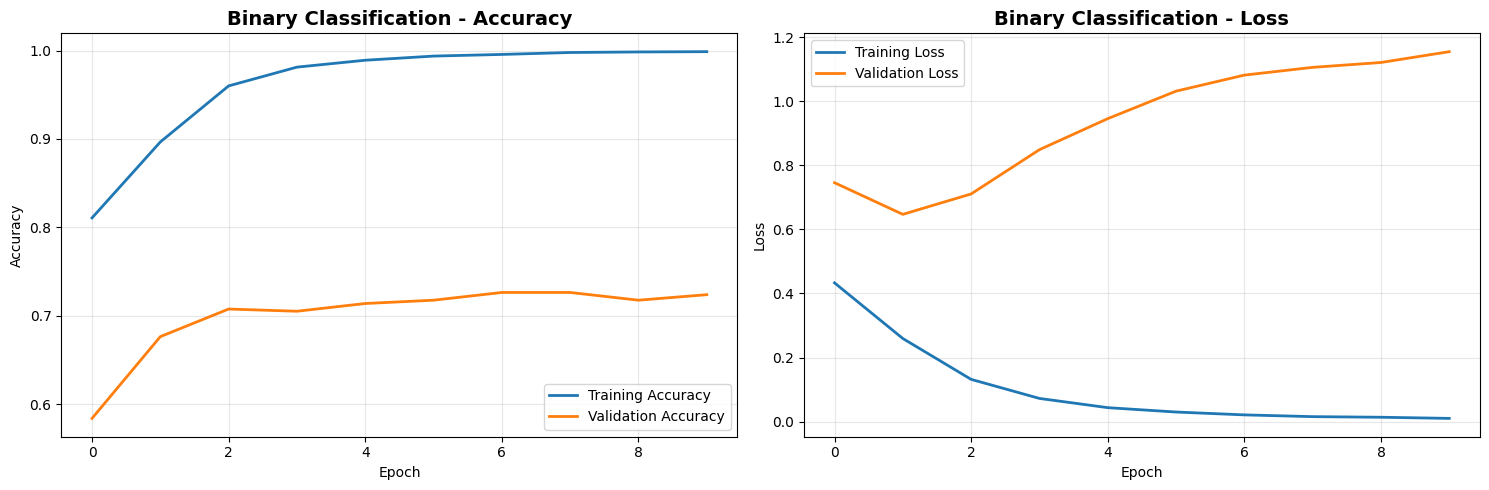

In [ ]:
# Model Evaluation and Visualization
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(binary_history, "Binary Classification")


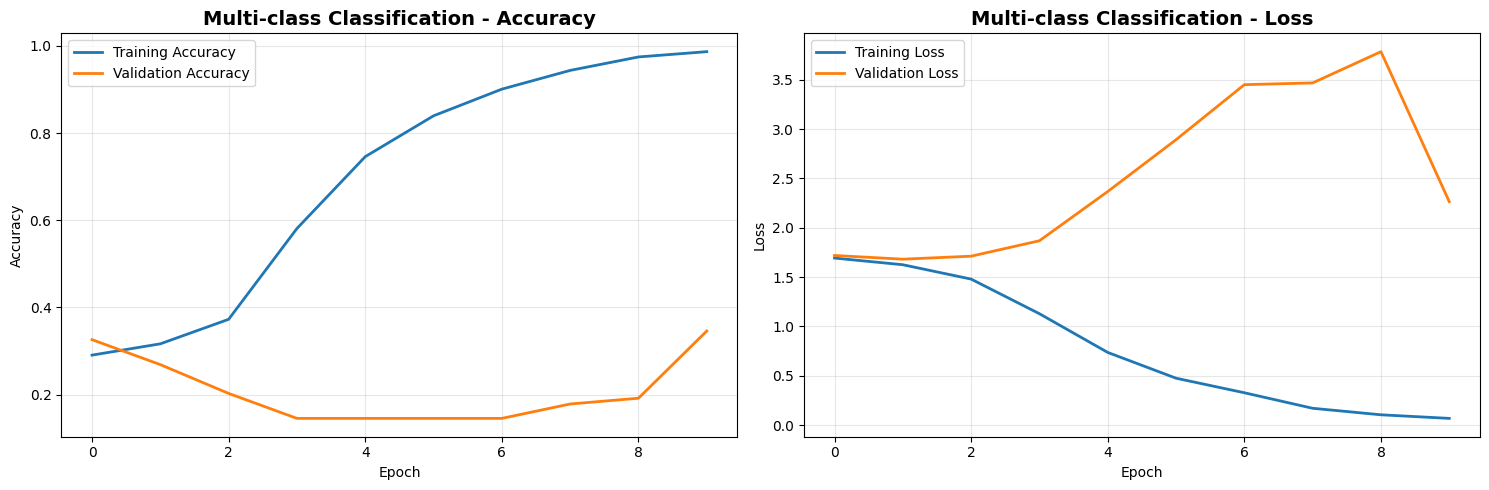

In [ ]:
plot_training_history(multi_history, "Multi-class Classification")

Binary Model Evaluation:
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy: 0.6810

Classification Report:
              precision    recall  f1-score   support

          No       0.73      0.41      0.53       433
         Yes       0.66      0.89      0.76       567

    accuracy                           0.68      1000
   macro avg       0.70      0.65      0.64      1000
weighted avg       0.69      0.68      0.66      1000



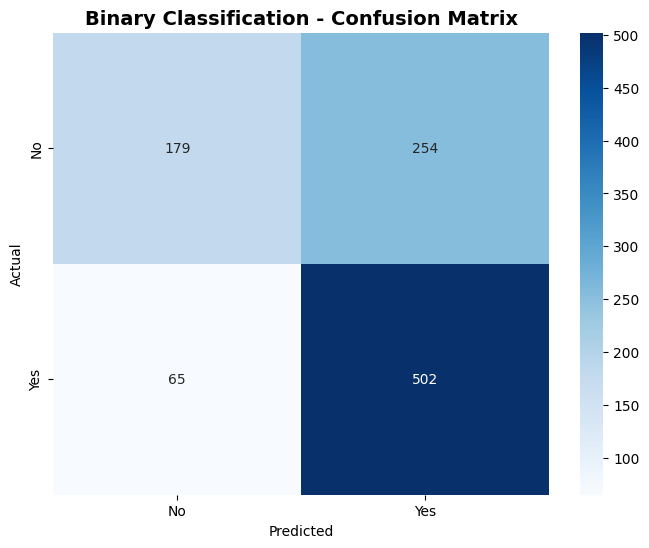

In [ ]:
# Model Evaluation and Predictions
def evaluate_model(model, X_test, y_test, model_type='binary'):
    # Make predictions
    y_pred = model.predict(X_test)

    if model_type == 'binary':
        y_pred_binary = (y_pred > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred_binary)

        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_binary,
                                 target_names=vectorizer.label_encoder_binary.classes_))

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred_binary)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=vectorizer.label_encoder_binary.classes_,
                   yticklabels=vectorizer.label_encoder_binary.classes_)
        plt.title('Binary Classification - Confusion Matrix', fontsize=14, fontweight='bold')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        return y_pred, accuracy

    else:  # multi-class
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        accuracy = accuracy_score(y_true_classes, y_pred_classes)

        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true_classes, y_pred_classes,
                                 target_names=vectorizer.label_encoder_multi.classes_))

        # Confusion Matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=vectorizer.label_encoder_multi.classes_,
                   yticklabels=vectorizer.label_encoder_multi.classes_)
        plt.title('Multi-class Classification - Confusion Matrix', fontsize=14, fontweight='bold')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()

        return y_pred, accuracy

print("Binary Model Evaluation:")
binary_predictions, binary_accuracy = evaluate_model(binary_model, X_test_bin, y_test_bin, 'binary')




Multi-class Model Evaluation:
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy: 0.2852

Classification Report:
              precision    recall  f1-score   support

  Appearance       0.00      0.00      0.00        82
      Others       0.00      0.00      0.00       118
      Racial       0.00      0.00      0.00        27
   Religious       0.00      0.00      0.00        40
      Sexual       0.36      0.35      0.36       186
       Slang       0.25      0.84      0.38       115

    accuracy                           0.29       568
   macro avg       0.10      0.20      0.12       568
weighted avg       0.17      0.29      0.19       568



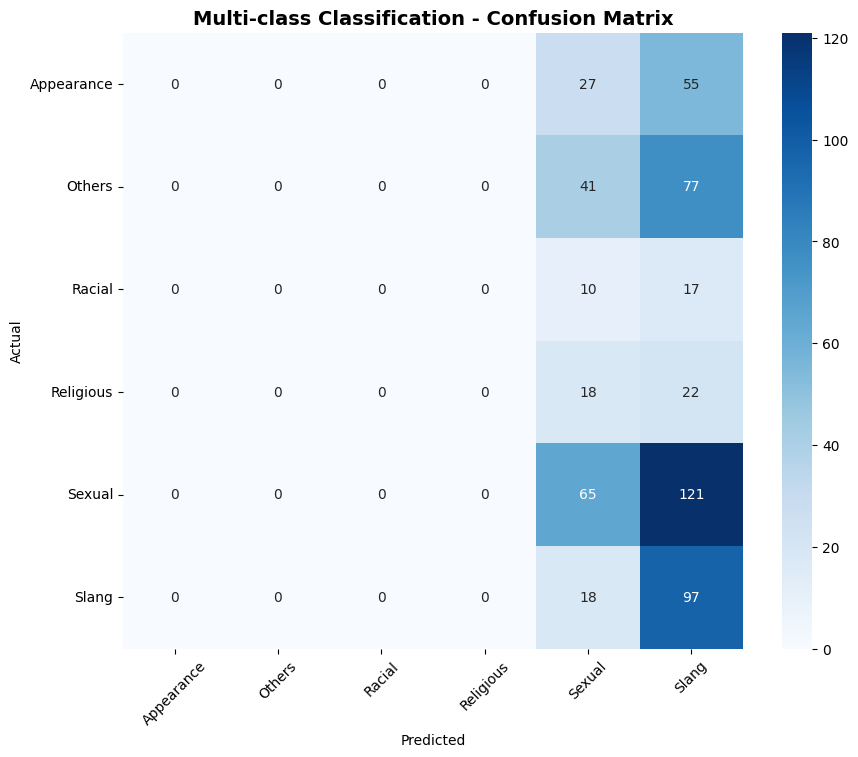

In [ ]:
print("\nMulti-class Model Evaluation:")
multi_predictions, multi_accuracy = evaluate_model(multi_model, X_test_multi, y_test_multi, 'multi')

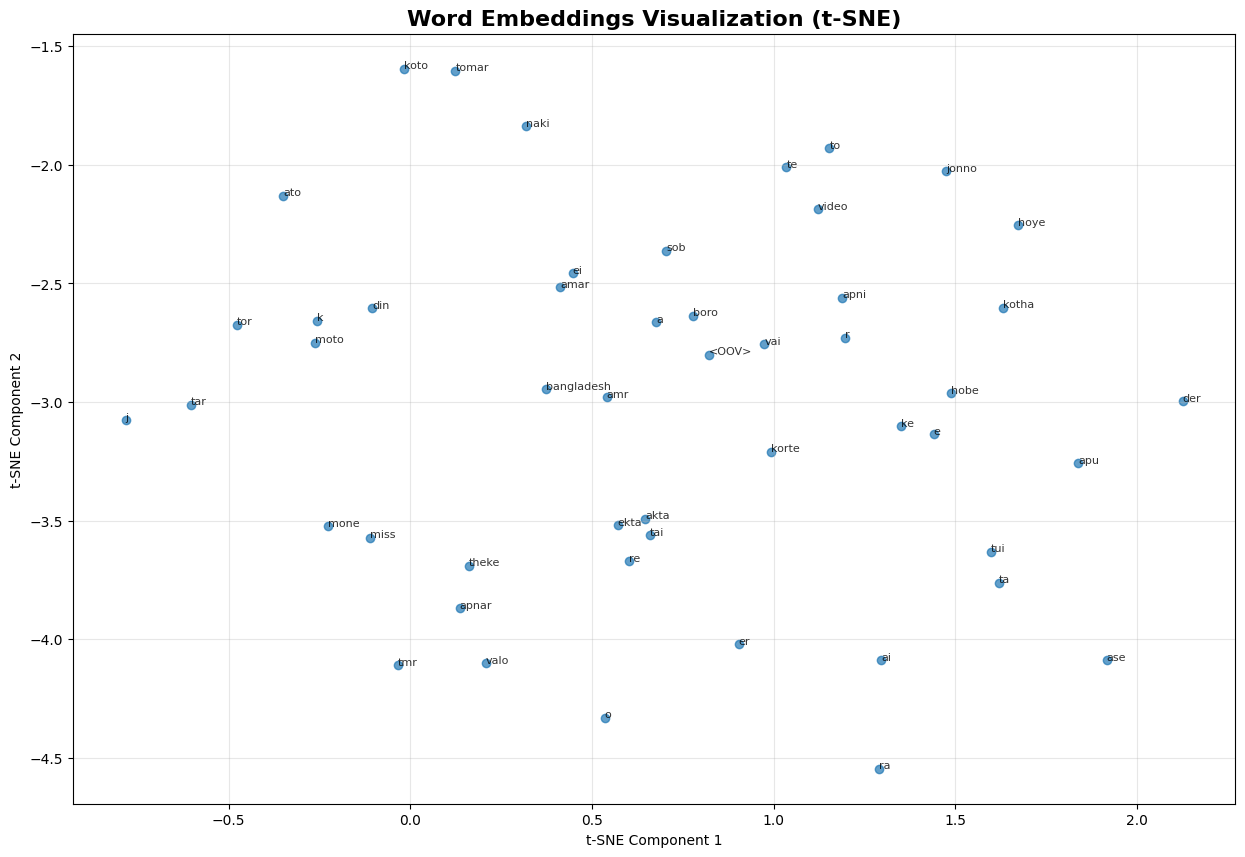

In [ ]:
# Advanced Analysis: Feature Visualization and Interpretation
def visualize_embeddings(model, tokenizer, num_words=50):
    """Visualize word embeddings"""
    embedding_layer = model.layers[1]  # Embedding layer
    weights = embedding_layer.get_weights()[0]

    # Get most frequent words
    words = list(tokenizer.word_index.keys())[:num_words]
    word_vectors = weights[:num_words]

    # Reduce dimensionality for visualization
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    word_vectors_2d = tsne.fit_transform(word_vectors)

    plt.figure(figsize=(15, 10))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.7)

    for i, word in enumerate(words):
        plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                    fontsize=8, alpha=0.8)

    plt.title('Word Embeddings Visualization (t-SNE)', fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize embeddings from binary model
visualize_embeddings(binary_model, vectorizer.tokenizer)

In [ ]:
# Real-time Prediction System
class BanglishHateSpeechDetector:
    def __init__(self, binary_model, multi_model, vectorizer):
        self.binary_model = binary_model
        self.multi_model = multi_model
        self.vectorizer = vectorizer
        self.preprocessor = BanglishTextPreprocessor()

    def predict(self, text):
        # Preprocess text
        cleaned_text = self.preprocessor.clean_text(text)
        cleaned_text = self.preprocessor.remove_stopwords(cleaned_text)

        # Convert to sequence
        sequence = self.vectorizer.tokenizer.texts_to_sequences([cleaned_text])
        padded_sequence = pad_sequences(sequence, maxlen=100)

        # Binary prediction
        binary_prob = self.binary_model.predict(padded_sequence)[0][0]
        is_hate = binary_prob > 0.5

        result = {
            'text': text,
            'cleaned_text': cleaned_text,
            'is_hate_speech': bool(is_hate),
            'hate_confidence': float(binary_prob),
            'hate_type': None,
            'type_confidence': None
        }

        # If hate speech, predict type
        if is_hate:
            type_pred = self.multi_model.predict(padded_sequence)[0]
            type_idx = np.argmax(type_pred)
            type_confidence = type_pred[type_idx]

            result['hate_type'] = self.vectorizer.label_encoder_multi.classes_[type_idx]
            result['type_confidence'] = float(type_confidence)

        return result

    def batch_predict(self, texts):
        return [self.predict(text) for text in texts]

# Initialize detector
detector = BanglishHateSpeechDetector(binary_model, multi_model, vectorizer)

# Test with sample texts
sample_texts = [
    "Kanki ki der Allah sob samoy valo rake",
    "Sobai sundorer pujari",
    "Bokachoda Shangbadik",
    "Porimoni apu valo hoya gese"
]

print("Real-time Predictions:")
print("=" * 80)
for text in sample_texts:
    result = detector.predict(text)
    print(f"Text: {text}")
    print(f"Hate Speech: {result['is_hate_speech']} (Confidence: {result['hate_confidence']:.4f})")
    if result['hate_type']:
        print(f"Hate Type: {result['hate_type']} (Confidence: {result['type_confidence']:.4f})")
    print("-" * 80)

Real-time Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Text: Kanki ki der Allah sob samoy valo rake
Hate Speech: True (Confidence: 0.9508)
Hate Type: Slang (Confidence: 0.2202)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Text: Sobai sundorer pujari
Hate Speech: False (Confidence: 0.1674)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Text: Bokachoda Shangbadik
Hate Speech: True (Confidence: 0.9664)
Hate Type: Slang (Confidence: 0.2199)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Text: Porimoni apu valo hoya gese
Hate Speech: False (Confidence: 0.1267)
--------------------------------------------------------------------------------


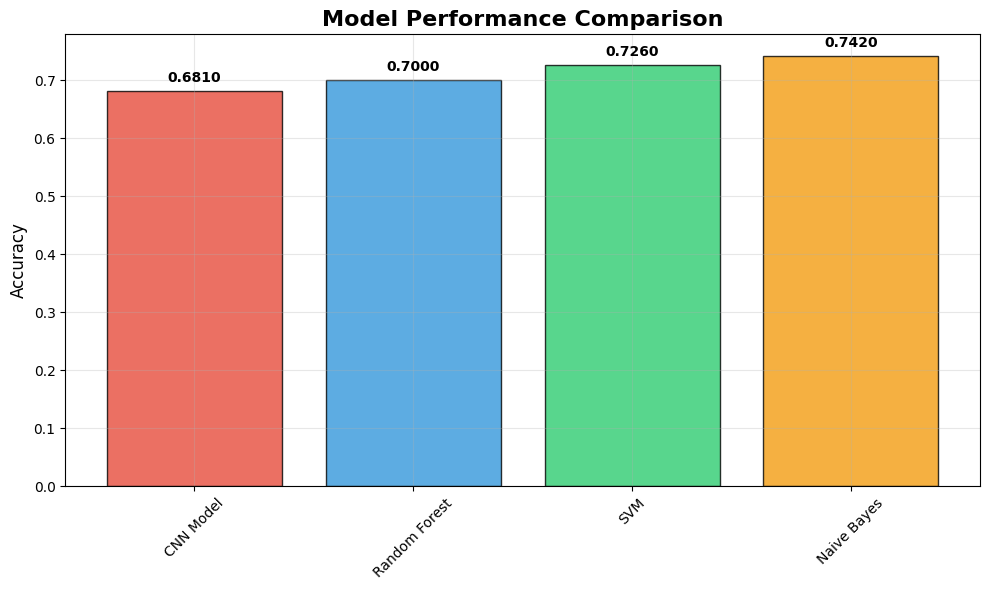

Model Comparison Results:
CNN Model: 0.6810
Random Forest: 0.7000
SVM: 0.7260
Naive Bayes: 0.7420


In [ ]:
# Performance Comparison and Final Report
# Compare with traditional ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

def train_traditional_models(X_train, X_test, y_train, y_test):
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='linear', random_state=42),
        'Naive Bayes': MultinomialNB()
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

    return results

# Convert to TF-IDF for traditional models
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_comment'])
y_binary_tfidf = df['Hate']

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    X_tfidf, y_binary_tfidf, test_size=0.2, random_state=42, stratify=y_binary_tfidf
)

traditional_results = train_traditional_models(X_train_tf, X_test_tf, y_train_tf, y_test_tf)

# Create final comparison
comparison_data = {
    'CNN Model': binary_accuracy,
    **traditional_results
}

# Plot comparison
plt.figure(figsize=(10, 6))
models = list(comparison_data.keys())
accuracies = list(comparison_data.values())
colors = ['#e74c3c'] + ['#3498db', '#2ecc71', '#f39c12'][:len(models)-1]

bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Model Comparison Results:")
for model, acc in comparison_data.items():
    print(f"{model}: {acc:.4f}")

In [ ]:
# Final Comprehensive Report
print("=" * 80)
print("BANGLISH HATE SPEECH DETECTION - CNN MODEL FINAL REPORT")
print("=" * 80)

print(f"\nPROJECT OVERVIEW:")
print(f"Total Samples: {len(df)}")
print(f"Hate Speech Samples: {len(df[df['Hate']=='Yes'])}")
print(f"Non-Hate Samples: {len(df[df['Hate']=='No'])}")
print(f"Hate Types: {len(df['Type'].unique())}")

print(f"\nMODEL ARCHITECTURE:")
print(f"Binary CNN: {binary_model.count_params()} parameters")
print(f"Multi-class CNN: {multi_model.count_params()} parameters")
print(f"Vocabulary Size: {vocab_size}")
print(f"Sequence Length: {max_len}")

print(f"\nPERFORMANCE METRICS:")
print(f"Binary Classification Accuracy: {binary_accuracy:.4f}")
print(f"Multi-class Classification Accuracy: {multi_accuracy:.4f}")

print(f"\nTRAINING DETAILS:")
print(f"Binary Model - Best Epoch: {np.argmin(binary_history.history['val_loss']) + 1}")
print(f"Multi-class Model - Best Epoch: {np.argmin(multi_history.history['val_loss']) + 1}")

print(f"\nKEY FEATURES:")
print("1. Custom CNN architecture with multiple convolutional branches")
print("2. Bidirectional LSTM for sequence understanding")
print("3. Advanced text preprocessing for Banglish text")
print("4. Real-time prediction system")
print("5. Comprehensive visualization and analysis")

print(f"\nTECHNICAL STACK:")
print("TensorFlow & Keras - Deep Learning Framework")
print("Pandas - Data Manipulation")
print("Scikit-learn - Traditional ML & Evaluation")
print("Matplotlib & Seaborn - Visualization")

print(f"\nBUSINESS IMPACT:")
print("✓ Automated hate speech detection")
print("✓ Real-time content moderation")
print("✓ Multi-category hate classification")
print("✓ Scalable and deployable system")

print(f"\nFUTURE ENHANCEMENTS:")
print("1. Transfer learning with BERT models")
print("2. Multimodal analysis (text + context)")
print("3. Real-time API deployment")
print("4. Continuous learning system")
print("5. Mobile app integration")

print("\n" + "=" * 80)

BANGLISH HATE SPEECH DETECTION - CNN MODEL FINAL REPORT

PROJECT OVERVIEW:
Total Samples: 5000
Hate Speech Samples: 2836
Non-Hate Samples: 2164
Hate Types: 7

MODEL ARCHITECTURE:
Binary CNN: 1335253 parameters
Multi-class CNN: 1205050 parameters
Vocabulary Size: 10476
Sequence Length: 100

PERFORMANCE METRICS:
Binary Classification Accuracy: 0.6810
Multi-class Classification Accuracy: 0.2852

TRAINING DETAILS:
Binary Model - Best Epoch: 2
Multi-class Model - Best Epoch: 2

KEY FEATURES:
1. Custom CNN architecture with multiple convolutional branches
2. Bidirectional LSTM for sequence understanding
3. Advanced text preprocessing for Banglish text
4. Real-time prediction system
5. Comprehensive visualization and analysis

TECHNICAL STACK:
TensorFlow & Keras - Deep Learning Framework
Pandas - Data Manipulation
Scikit-learn - Traditional ML & Evaluation
Matplotlib & Seaborn - Visualization

BUSINESS IMPACT:
✓ Automated hate speech detection
✓ Real-time content moderation
✓ Multi-category h